# 今回の取り組み

- `call_midsv`の内部処理を可能な限りGeneratorに変更します

## いつものセットアップ

In [2]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [3]:
%%bash
pip uninstall -qy DAJIN2
# pipの更新
# pip install -q -U pip
# pip install -q -U -r requirements.txt

# 実験

In [4]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

reload(preprocess)
reload(classification)
reload(clustering)
reload(consensus)
reload(report)

#### # * Subset of Point mutation
#### # 50 or 10 or 01%
percent = "50"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    f"misc/data/tyr_albino_{percent}%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "single-tyr50",
    "mm10",
    True,
    30,
)


######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

SAMPLE = preprocess.format_inputs.convert_to_posix_path(SAMPLE)
CONTROL = preprocess.format_inputs.convert_to_posix_path(CONTROL)
ALLELE = preprocess.format_inputs.convert_to_posix_path(ALLELE)

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-tyr50...


In [9]:
import pickle
for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
    )
# ============================================================
# MIDSV conversion
# ============================================================
midsv_control_alleles = preprocess.call_midsv(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
# ============================================================
# Convert any `N` as deletions other than consecutive `N` from both ends
# ============================================================
midsv_control_alleles = preprocess.replace_NtoD(midsv_control_alleles, FASTA_ALLELES)
###########################################################
# Save MIDSV and BAM
###########################################################
with open(Path(TEMPDIR, "midsv", f"{CONTROL_NAME}.plk"), 'wb') as p:
    pickle.dump(midsv_control_alleles, p)
report.report_bam.output_bam_control(TEMPDIR, CONTROL_NAME, GENOME, GENOME_COODINATES, CHROME_SIZE, THREADS)


In [5]:
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
    )


In [10]:
midsv_sample_alleles = preprocess.call_midsv(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
print(len(midsv_sample_alleles))
print(type(midsv_sample_alleles))

1
<class 'dict'>


In [8]:
print(type(midsv_sample_alleles["control"]))

<class 'itertools.chain'>


In [12]:
print(len(list(midsv_sample_alleles["control"])))

0


In [13]:
from __future__ import annotations

import midsv
from pathlib import Path
import re
from itertools import groupby
from itertools import chain
import pickle
from typing import Generator


def _load_sam(path_sam: str | Path) -> Generator[list[str]]:
    return midsv.read_sam(path_sam)

def _split_cigar(CIGAR:str) -> list[str]:
    cigar = re.split(r"([MIDNSH=X])", CIGAR)
    n = len(cigar)
    cigar_split = []
    for i, j in zip(range(0, n, 2), range(1, n, 2)):
        cigar_split.append(cigar[i] + cigar[j])
    return cigar_split


def _call_alignment_length(CIGAR: str) -> int:
    cigar_split = _split_cigar(CIGAR)
    alignment_length = 0
    for c in cigar_split:
        if re.search(r"[MDN=X]", c[-1]):
            alignment_length += int(c[:-1])
    return alignment_length



def _has_inversion_in_splice(CIGAR: str) -> bool:
    is_splice = False
    is_insertion = False
    for cigar in _split_cigar(CIGAR):
        if cigar.endswith("I"):
            is_insertion = True
            continue
        if is_insertion and cigar.endswith("N"):
            is_splice = True
            break
        else:
            is_insertion = False
    return is_splice


def _extract_qname_of_map_ont(sam_ont: Generator[list[str]], sam_splice: Generator[list[str]]) -> set():
    """Extract qname of reads from `map-ont` when:
        - no inversion signal in `splice` alignment (insertion + deletion)
        - single read
        - long alignment length
    """
    dict_alignments_splice = {s[0]: s for s in sam_splice if not s[0].startswith("@")}
    alignments_ont = [s for s in sam_ont if not s[0].startswith("@")]
    alignments_ont.sort(key=lambda x: x[0])
    qname_of_map_ont = set()
    for qname_ont, group in groupby(alignments_ont, key=lambda x: x[0]):
        alignment_ont = list(group)
        if not qname_ont in dict_alignments_splice:
            qname_of_map_ont.add(qname_ont)
            continue
        alignment_splice = dict_alignments_splice[qname_ont]
        if _has_inversion_in_splice(alignment_splice[5]):
            qname_of_map_ont.add(qname_ont)
            continue
        if len(alignment_ont) != 1:
            continue
        alignment_ont = alignment_ont[0]
        alignment_length_ont = _call_alignment_length(alignment_ont[5])
        alignment_length_splice = _call_alignment_length(alignment_splice[5])
        if alignment_length_ont >= alignment_length_splice:
            qname_of_map_ont.add(qname_ont)
    return qname_of_map_ont


def _extract_sam(sam: Generator[list[str]], qname_of_map_ont: set, preset:str="map-ont") -> Generator[list[str]]:
    for alignment in sam:
        if alignment[0].startswith("@"):
            yield alignment
        if preset == "map-ont":
            if alignment[0] in qname_of_map_ont:
                yield alignment
        else:
            if alignment[0] not in qname_of_map_ont:
                yield alignment


def _midsv_transform(sam: Generator[list[str]]) -> Generator[list[str]]:
    for midsv_sample in midsv.transform(sam, midsv=False, cssplit=True, qscore=False):
        yield midsv_sample


def _replaceNtoD(midsv_sample: Generator[list[str]], sequence: str) -> list[list[str]]:
    cssplits_replaced = []
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        # extract right/left index of the end of sequential Ns
        left_idx_n = 0
        for cs in cssplits:
            if cs != "N":
                break
            left_idx_n += 1
        right_idx_n = 0
        for cs in cssplits[::-1]:
            if cs != "N":
                break
            right_idx_n += 1
        right_idx_n = len(cssplits) - right_idx_n - 1
        # replace sequential Ns within the sequence
        for j, (cs, seq) in enumerate(zip(cssplits, sequence)):
            if left_idx_n <= j <= right_idx_n and cs == "N":
                cssplits[j] = f"-{seq}"
        cssplits_replaced.append(",".join(cssplits))
    # Update midsv
    for i, samp in enumerate(midsv_sample):
        samp["CSSPLIT"] = cssplits[i]
    return midsv_sample



def call_midsv(TEMPDIR: Path | str, FASTA_ALLELES: dict, SAMPLE_NAME: str) -> dict[list[list[str]]]:
    midsv_sample = dict()
    for allele, sequence in FASTA_ALLELES.items():
        path_sam_ont = f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam"
        path_sam_splice = f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam"
        qname_of_map_ont = _extract_qname_of_map_ont(_load_sam(path_sam_ont), _load_sam(path_sam_splice))
        sam_of_map_ont = _extract_sam(_load_sam(path_sam_ont), qname_of_map_ont, preset="map-ont")
        sam_of_splice = _extract_sam(_load_sam(path_sam_splice), qname_of_map_ont, preset="splice")
        midsv_of_single_read = _midsv_transform(sam_of_map_ont)
        midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
        midsv_sample[allele] = _replaceNtoD(chain(midsv_of_single_read, midsv_of_multiple_reads), sequence)
    # print("PICKLED MIDSV!!") #! ==================================
    # with open(Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}.plk"), 'wb') as p:
    #     pickle.dump(midsv_sample, p)
    return midsv_sample


In [14]:
allele = "control"
sequence = FASTA_ALLELES[allele]

In [20]:
path_sam_ont = f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam"
path_sam_splice = f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam"
qname_of_map_ont = _extract_qname_of_map_ont(_load_sam(path_sam_ont), _load_sam(path_sam_splice))
sam_of_map_ont = _extract_sam(_load_sam(path_sam_ont), qname_of_map_ont, preset="map-ont")
sam_of_splice = _extract_sam(_load_sam(path_sam_splice), qname_of_map_ont, preset="splice")
midsv_of_single_read = _midsv_transform(sam_of_map_ont)
midsv_of_multiple_reads = _midsv_transform(sam_of_splice)


In [19]:
x = chain(midsv_of_single_read, midsv_of_multiple_reads)
print(next(x))

{'QNAME': '00077750-d7ab-4c73-ac65-8707d39936c2', 'RNAME': 'control', 'CSSPLIT': '=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,+G|=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,+A|=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,-G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,*AG,*GA,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,+A|+A|=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=

In [28]:
def _replaceNtoD(midsv_sample: Generator[list[str]], sequence: str) -> Generator[list[str]]:
    cssplits_replaced = []
    for cssplits in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        # extract right/left index of the end of sequential Ns
        left_idx_n = 0
        for cs in cssplits:
            if cs != "N":
                break
            left_idx_n += 1
        right_idx_n = 0
        for cs in cssplits[::-1]:
            if cs != "N":
                break
            right_idx_n += 1
        right_idx_n = len(cssplits) - right_idx_n - 1
        # replace sequential Ns within the sequence
        for j, (cs, seq) in enumerate(zip(cssplits, sequence)):
            if left_idx_n <= j <= right_idx_n and cs == "N":
                cssplits[j] = f"-{seq}"
        cssplits_replaced.append(",".join(cssplits))
    # Update midsv
    for i, samp in enumerate(midsv_sample):
        samp["CSSPLIT"] = cssplits_replaced[i]
        yield samp

In [31]:
path_sam_ont = f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam"
path_sam_splice = f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam"
qname_of_map_ont = _extract_qname_of_map_ont(_load_sam(path_sam_ont), _load_sam(path_sam_splice))
sam_of_map_ont = _extract_sam(_load_sam(path_sam_ont), qname_of_map_ont, preset="map-ont")
sam_of_splice = _extract_sam(_load_sam(path_sam_splice), qname_of_map_ont, preset="splice")
midsv_of_single_read = _midsv_transform(sam_of_map_ont)
midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
x = chain(midsv_of_single_read, midsv_of_multiple_reads)
# x = _replaceNtoD(chain(midsv_of_single_read, midsv_of_multiple_reads), sequence)
for i, samp in enumerate(x):
    print(samp["CSSPLIT"])
    if i == 3:
        break

=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,+G|=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,+A|=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,-G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,*AG,*GA,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,+A|+A|=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,=C,=A,+T|+T|=T,=T,=T,*GA,=C,=A,=A,=A,=T,=T,=C,=C,=A,=A,=T,=T,=A,=T,=

In [57]:
def _replaceNtoD(midsv_sample: Generator[list[str]], sequence: str) -> Generator[tuple[str, str]]:
    for samp in midsv_sample:
        qname = samp["QNAME"]
        cssplits = samp["CSSPLIT"].split(",")
        # extract right/left index of the end of sequential Ns
        left_idx_n = 0
        for cs in cssplits:
            if cs != "N":
                break
            left_idx_n += 1
        right_idx_n = 0
        for cs in cssplits[::-1]:
            if cs != "N":
                break
            right_idx_n += 1
        right_idx_n = len(cssplits) - right_idx_n - 1
        # replace sequential Ns within the sequence
        for j, (cs, seq) in enumerate(zip(cssplits, sequence)):
            if left_idx_n <= j <= right_idx_n and cs == "N":
                cssplits[j] = f"-{seq}"
        yield (qname, ",".join(cssplits))



In [60]:
path_sam_ont = f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam"
path_sam_splice = f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam"
qname_of_map_ont = _extract_qname_of_map_ont(_load_sam(path_sam_ont), _load_sam(path_sam_splice))
sam_of_map_ont = _extract_sam(_load_sam(path_sam_ont), qname_of_map_ont, preset="map-ont")
sam_of_splice = _extract_sam(_load_sam(path_sam_splice), qname_of_map_ont, preset="splice")
midsv_of_single_read = _midsv_transform(sam_of_map_ont)
midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
# for samp in chain(midsv_of_single_read, midsv_of_multiple_reads):
#     print(samp["QNAME"])
#     print(samp["CSSPLIT"])
#     for qname, cssplits in zip(samp["QNAME"], samp["CSSPLIT"].split(",")):
#         print(qname, cssplits)
#         break
x = _replaceNtoD(chain(midsv_of_single_read, midsv_of_multiple_reads), sequence)


In [61]:
print(next(x))
print(next(x))

('00077750-d7ab-4c73-ac65-8707d39936c2', '=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,+G|=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,+A|=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,-G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,*AG,*GA,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,+A|+A|=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,=C,=A,+T|+T|=T,=T,=T,*GA,=

In [21]:
from __future__ import annotations

import midsv
from pathlib import Path
import re
from itertools import groupby


def _split_cigar(CIGAR:str) -> list[str]:
    cigar = re.split(r"([MIDNSH=X])", CIGAR)
    n = len(cigar)
    cigar_split = []
    for i, j in zip(range(0, n, 2), range(1, n, 2)):
        cigar_split.append(cigar[i] + cigar[j])
    return cigar_split


def _call_alignment_length(CIGAR: str) -> int:
    cigar_split = _split_cigar(CIGAR)
    alignment_length = 0
    for c in cigar_split:
        if re.search(r"[MDN=X]", c[-1]):
            alignment_length += int(c[:-1])
    return alignment_length



def _has_inversion_in_splice(CIGAR: str) -> bool:
    is_splice = False
    is_insertion = False
    for cigar in _split_cigar(CIGAR):
        if cigar.endswith("I"):
            is_insertion = True
            continue
        if is_insertion and cigar.endswith("N"):
            is_splice = True
            break
        else:
            is_insertion = False
    return is_splice


def _extract_qname_of_map_ont(sam_ont: list[list[str]], sam_splice: list[list[str]]) -> set():
    """Extract qname of reads from `map-ont` when:
        - no inversion signal in `splice` alignment (insertion + deletion)
        - single read
        - long alignment length
    """
    alignments_ont = [s for s in sam_ont if not s[0].startswith("@")]
    dict_alignments_splice = {s[0]: s for s in sam_splice if not s[0].startswith("@")}
    alignments_ont.sort(key=lambda x: x[0])
    qname_of_map_ont = set()
    for qname_ont, group in groupby(alignments_ont, key=lambda x: x[0]):
        alignment_ont = list(group)
        if not qname_ont in dict_alignments_splice:
            qname_of_map_ont.add(qname_ont)
            continue
        alignment_splice = dict_alignments_splice[qname_ont]
        if _has_inversion_in_splice(alignment_splice[5]):
            qname_of_map_ont.add(qname_ont)
            continue
        if len(alignment_ont) != 1:
            continue
        alignment_ont = alignment_ont[0]
        alignment_length_ont = _call_alignment_length(alignment_ont[5])
        alignment_length_splice = _call_alignment_length(alignment_splice[5])
        if alignment_length_ont >= alignment_length_splice:
            qname_of_map_ont.add(qname_ont)
    return qname_of_map_ont


def _extract_sam(sam: list[list[str]], qname_of_map_ont: set, preset:str="map-ont") -> list[list[str]]:
    sam_extracted = []
    for alignment in sam:
        if alignment[0].startswith("@"):
            sam_extracted.append(alignment)
        if preset == "map-ont":
            if alignment[0] in qname_of_map_ont:
                sam_extracted.append(alignment)
        else:
            if alignment[0] not in qname_of_map_ont:
                sam_extracted.append(alignment)
    return sam_extracted


def _midsv_transform(sam: list[list[str]]) -> list[list[str]]:
    num_header = 0
    for s in sam:
        if s[0].startswith("@"):
            num_header += 1
        else:
            break
    if len(sam) == num_header:
        return []
    return midsv.transform(sam, midsv=False, cssplit=True, qscore=False)


def call_midsv(TEMPDIR: Path | str, FASTA_ALLELES: dict, SAMPLE_NAME: str) -> dict[str, list[dict]]:
    midsv_sample = dict()
    for allele in FASTA_ALLELES:
        sam_ont = list(midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_map-ont_{allele}.sam"))
        sam_splice = list(midsv.read_sam(f"{TEMPDIR}/sam/{SAMPLE_NAME}_splice_{allele}.sam"))
        qname_of_map_ont = _extract_qname_of_map_ont(sam_ont, sam_splice)
        sam_of_map_ont = _extract_sam(sam_ont, qname_of_map_ont, preset="map-ont")
        sam_of_splice = _extract_sam(sam_splice, qname_of_map_ont, preset="splice")
        midsv_of_single_read = _midsv_transform(sam_of_map_ont)
        midsv_of_multiple_reads = _midsv_transform(sam_of_splice)
        midsv_sample[allele] = midsv_of_single_read + midsv_of_multiple_reads
    return midsv_sample


In [57]:
midsv_control_alleles = call_midsv(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
midsv_control_alleles = preprocess.replace_NtoD(midsv_control_alleles, FASTA_ALLELES)

In [58]:
midsv_sample_alleles = call_midsv(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [59]:
print(len(midsv_sample_alleles["control"]))

5000


In [60]:
midsv_sample_alleles = preprocess.replace_NtoD(midsv_sample_alleles, FASTA_ALLELES)
print(len(midsv_sample_alleles["control"]))

5000


In [62]:
midsv_sample_alleles = preprocess.call_midsv(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
MUTATION_LOCI_ALLELES = preprocess.extract_mutation_loci(midsv_sample_alleles, midsv_control_alleles)
print(MUTATION_LOCI_ALLELES)

{'control': {'ins': {1272, 769, 516, 2574, 2576, 1426, 1427, 1429, 1687, 282, 2330, 158, 2079, 2208, 2083, 292, 1702, 296, 299, 556, 2477, 558, 1708, 562, 1077, 1717, 2240, 1600, 325, 1483, 205, 207, 1615, 213, 351, 619, 2037, 504, 2301, 1790}, 'del': {1538, 1038, 2586, 2587, 1062, 1064, 2092, 1069, 1071, 1075, 1077, 1078, 1589, 1080, 1592, 1082, 1593, 1100, 2126, 2127, 1105, 1617, 1107, 1108, 1109, 1618, 603, 1116, 606, 607, 2660, 2661, 2662, 104, 1139, 117, 118, 1145, 1665, 643, 2692, 2693, 1156, 1667, 648, 1176, 1689, 666, 672, 686, 2736, 2737, 1713, 1206, 706, 2262, 1246, 1758, 1759, 1769, 237, 1775, 243, 1271, 257, 1795, 772, 261, 2820, 1289, 267, 1298, 1304, 1817, 797, 1829, 296, 297, 298, 1332, 825, 1339, 828, 1346, 1863, 2393, 1888, 360, 1390, 2419, 889, 384, 897, 898, 899, 388, 1417, 907, 908, 418, 1460, 1972, 951, 1468, 1994, 1995, 1490, 1491, 1513, 1009, 1523, 1525, 502, 1526, 2037, 2038, 510}, 'sub': {2053, 2059, 2578, 2585, 1561, 544, 1057, 1058, 1570, 548, 1060, 2088, 261

In [63]:
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)

In [64]:
midsv_alleles_corrected = preprocess.correct_sequence_error(midsv_sample_alleles, midsv_control_alleles, FASTA_ALLELES, MUTATION_LOCI_ALLELES)

In [65]:
print(len(midsv_alleles_corrected["sample"]["control"]))
print(len(midsv_alleles_corrected["control"]["control"]))

5000
10000


In [66]:
classif_sample = classification.classify_alleles(midsv_alleles_corrected["sample"], TEMPDIR)

In [67]:
print(len(classif_sample))

5000


In [68]:
clust_sample = clustering.add_labels(classif_sample, midsv_alleles_corrected["control"], MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS)
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)

- Generatorとしたために`calc_midsv`の`sam_ont`などが再利用できなかったのが原因でした

In [73]:
%%bash
rm -rf DAJINResults/single-tyr50
rm -rf DAJINResults/.tempdir/single-tyr50

pip install -qe .
time DAJIN2 \
    --name single-tyr50 \
    --sample "misc/data/tyr_albino_50%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10 \
    --threads 10

(60648822374, -1)
misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_control.fq.gz is finished...
misc/data/tyr_albino_50%.fq.gz is now processing...
2023-04-28 12:51:46: Preprocess tyr_albino_50%...
2023-04-28 12:51:46: mapping tyr_albino_50%...
2023-04-28 12:51:55: midsv tyr_albino_50%...
2023-04-28 12:51:58: replace_NtoD tyr_albino_50%...
2023-04-28 12:52:00: extract_mutation_loci tyr_albino_50%...
2023-04-28 12:52:13: correct_sequence_error tyr_albino_50%...
2023-04-28 12:52:34: Classify tyr_albino_50%...
2023-04-28 12:52:35: Clustering tyr_albino_50%...
2023-04-28 12:52:55: Consensus calling tyr_albino_50%......
misc/data/tyr_albino_50%.fq.gz is finished...


Finished! Open DAJINResults/single-tyr50 to see the report.

real	1m58.954s
user	1m43.058s
sys	0m3.734s


- エラーなく、結果も問題なさそうです。

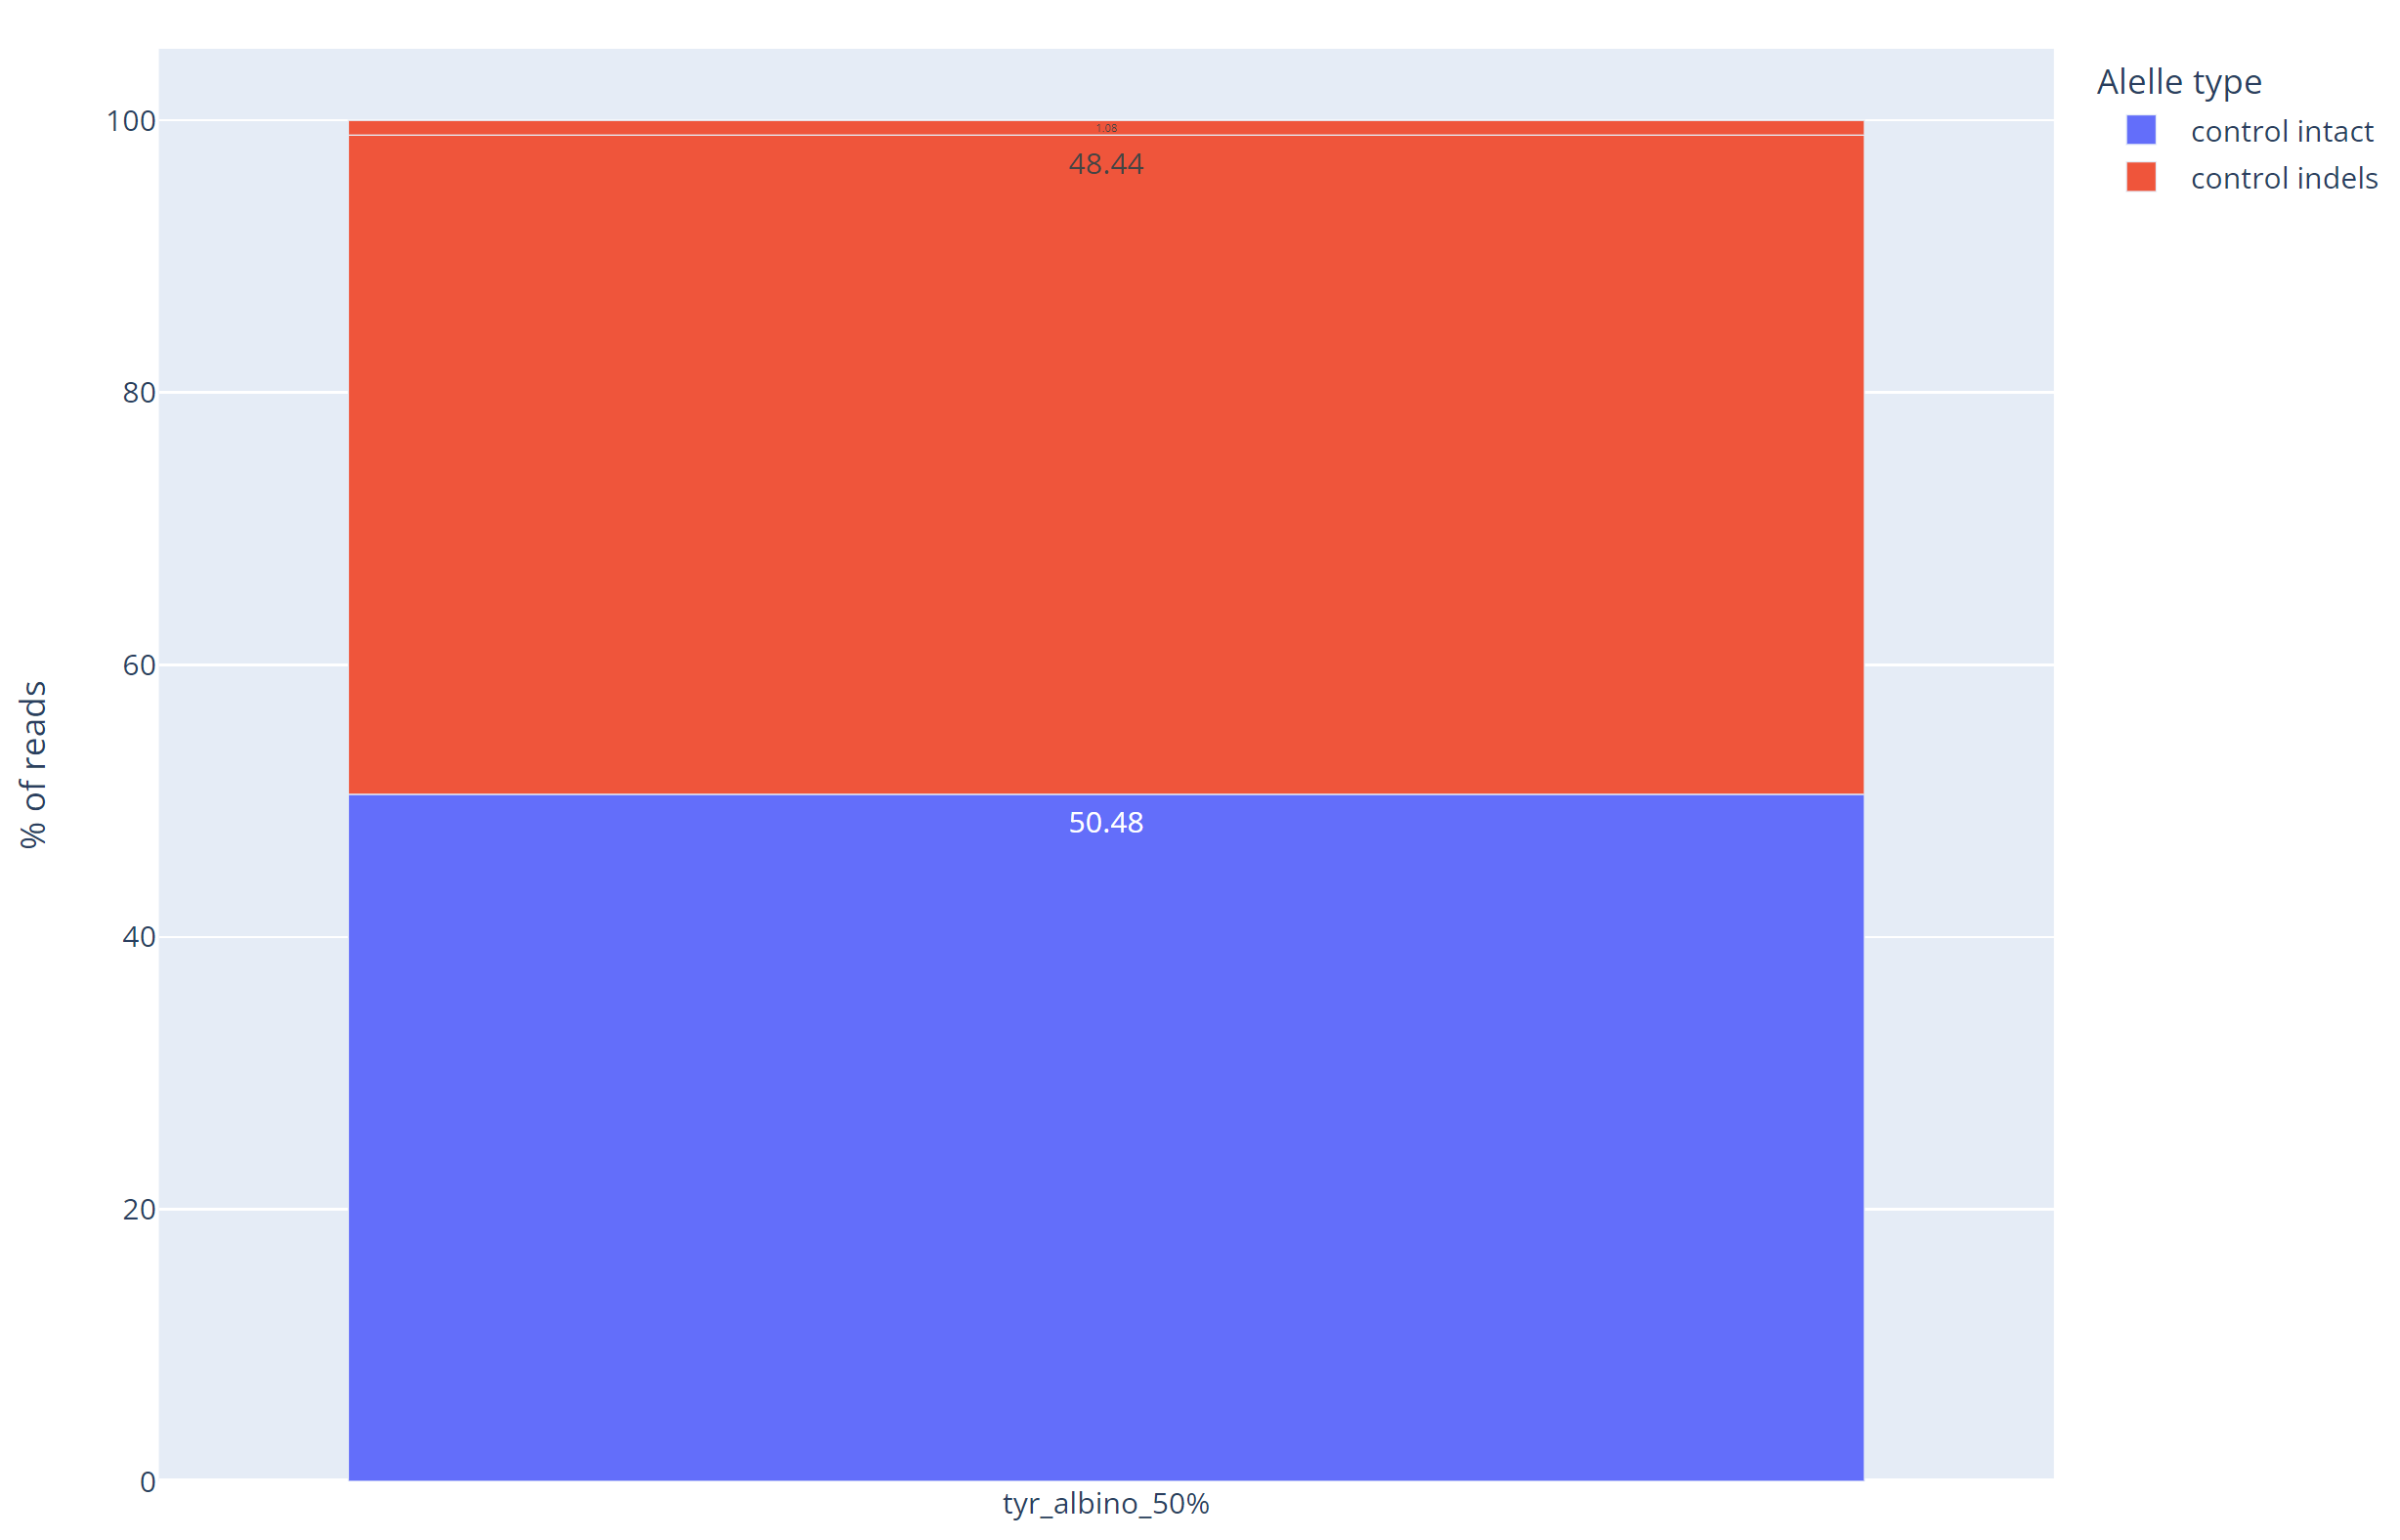

- いまだにリアルのサンプルではメモリーエラーが出ているようです
- 重たいデータは`pickle`オブジェクトに保管して、メモリ上の大きさを観察します
- サンプル自体を並列処理するとメモリがやられてしまうので、**各サンプルごとの処理を効率化する**ほうが良さそうです

- memory_profilerでリアルサンプルの`extract_mutation_loci`におけるメモリ消費量を見てみると、`cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]`がメモリをバカ食いしていました

```
Line #    Mem usage    Increment  Occurrences   Line Contents
=============================================================
    87   2164.8 MiB   2164.8 MiB           1   @profile     
    88                        
                 def extract_mutation_loci(midsv_sample_alleles, midsv_control_alleles) -> dict[str, dict[str, set[int]]]:
    89   2164.8 MiB      0.0 MiB           1       MUTATION_LOCI_ALLELES = dict()
    90  24838.2 MiB      0.0 MiB           3       for allele in midsv_sample_alleles:    
    91  23550.6 MiB      0.0 MiB           2           midsv_sample = midsv_sample_alleles[allele]
    92  23550.6 MiB      0.0 MiB           2           midsv_control = midsv_control_alleles[allele]
    93  34499.7 MiB  12241.7 MiB      115018           cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
    94  34040.5 MiB    779.8 MiB      109410           cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsviB           2           mutation_loci = dict()
   104  24838.2 MiB      0.0 MiB           2           MUTATION_LOCI_ALLELES.update({allele: mutation_loci})      
   105  24838.2 MiB      0.0 MiB           1       return MUTATION_LOCI_ALLELES
```

In [112]:
def _count_indels(midsv_sample, len_sequence: int) -> dict[str, list[int]]:
    count = {"ins": [0] * len_sequence,
            "del": [0] * len_sequence,
            "sub": [0] * len_sequence}
    for samp in midsv_sample:
        for i, cs in enumerate(samp["CSSPLIT"].split(",")):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["ins"][i] += len(cs.split("|"))
                count["ins"][i] += 1
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

In [113]:
allele = "control"
sequence = FASTA_ALLELES[allele]
midsv_sample = midsv_sample_alleles[allele]
midsv_control = midsv_control_alleles[allele]

x = _count_indels(midsv_sample, len(sequence))

In [116]:
print(x["sub"][828])

2480


- CSSPLITSを明示的にするのはやめて、for文で少しずつ処理していくようにしました。
    - まずは`extract_mutation_loci`を変更しました

In [123]:
from typing import Generator

def _yield_cssplits(midsv_sample: dict) -> Generator[list[str]]:
    return (cs["CSSPLIT"].split(",") for cs in midsv_sample)


In [128]:
x = _yield_cssplits(midsv_sample)
print(type(x))
x = _yield_cssplits(midsv_sample)
print(type(list(x)))
x = _yield_cssplits(midsv_sample)
print(next(x))

<class 'generator'>
<class 'list'>
['=T', '=G', '=C', '=A', '=T', '=T', '=G', '=A', '=A', '=G', '=C', '=A', '=G', '=T', '=T', '=C', '=A', '=C', '=C', '=A', '=A', '=A', '=A', '=T', '=A', '=A', '=C', '=A', '=A', '=A', '=G', '=T', '=A', '=A', '=C', '=A', '=A', '=A', '=G', '=T', '=A', '=A', '=G', '=A', '=T', '=A', '=T', '=C', '=T', '=T', '=T', '=G', '=G', '=A', '=A', '=T', '=A', '=A', '=T', '=C', '=A', '=A', '=T', '=T', '=C', '=A', '=A', '=G', '=A', '=T', '=A', '=A', '=T', '=C', '=A', '=A', '=G', '=G', '=A', '=A', '=A', '=A', '=A', '=T', '=G', '=A', '=G', '=A', '=G', '=G', '=C', '=A', '=A', '=C', '=T', '=A', '=T', '=T', '=T', '=T', '=A', '=G', '=A', '=C', '=T', '=G', '=A', '=T', '=T', '=A', '=C', '=T', '=T', '=T', '=T', '=A', '=T', '=A', '=A', '=A', '=A', '=T', '=A', '=A', '=A', '=T', '=A', '=A', '=G', '=C', '=T', '=C', '=A', '=G', '=C', '=T', '=T', '=A', '=G', '=C', '=C', '=A', '=G', '=A', '=T', '=A', '=T', '=A', '=A', '=G', '=C', '=A', '=A', '=T', '=A', '=T', '=T', '=C', '=T', '=G', '=A'

In [147]:
def init():
    return list("N")
# cssplits_sampling_kmer = defaultdict(lambda: defaultdict(init))
cssplits_sampling_kmer = defaultdict(lambda: defaultdict(lambda: list("N")))
cssplits_sampling_kmer["hoge"]["fuga"]
print(cssplits_sampling_kmer["hoge"]["fuga"])

['N']


In [ ]:
midsv_sample_alleles = preprocess.call_midsv(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
midsv_control_alleles = preprocess.call_midsv(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
MUTATION_LOCI_ALLELES = preprocess.extract_mutation_loci(midsv_sample_alleles, midsv_control_alleles)
allele = "control"
midsv_sample = midsv_sample_alleles[allele]
mutation_loci = MUTATION_LOCI_ALLELES[allele]
# print(next(cssplits_replaced))


In [10]:
import re
def _yield_cssplits(midsv_sample: dict) -> Generator[list[str]]:
    return (cs["CSSPLIT"].split(",") for cs in midsv_sample)


def _replace_errors_to_atmark(midsv_sample: dict, mutation_loci: dict[str, set[int]]) -> Generator[list[str]]:
    for cssplits in _yield_cssplits(midsv_sample):
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        yield cssplits_replaced





In [11]:
cssplits_replaced = _replace_errors_to_atmark(midsv_sample, mutation_loci)

In [12]:
def _create_replace_dict(cssplits_replaced: Generator[list[str]], sequence: str) -> dict[str, dict[str, int]]:
    cssplits_atmark = defaultdict(set)
    cssplits_sampling = defaultdict(lambda: defaultdict(lambda: list("N")))
    for read_idx, cssplits in enumerate(cssplits_replaced):
        for seq_idx, cs in enumerate(cssplits):
            if seq_idx == 0 or seq_idx == len(cssplits) - 1:
                continue
            kmer = ",".join([cssplits[seq_idx - 1], cssplits[seq_idx + 1]])
            if cs == "@":
                cssplits_atmark[seq_idx].add(kmer)
            else:
                cssplits_sampling[seq_idx][kmer].append(cs)
    return cssplits_atmark, cssplits_sampling


cssplits_replaced = _replace_errors_to_atmark(midsv_sample, mutation_loci)
sequence = FASTA_ALLELES[allele]
cssplits_atmark, cssplits_sampling = _create_replace_dict(cssplits_replaced, sequence)

In [22]:
import sys
print(sys.getsizeof(cssplits_atmark))
print(sys.getsizeof(cssplits_sampling))
print(len(cssplits_atmark.keys()))
print(cssplits_atmark[828])
print(cssplits_sampling[1])

147560
147560
2838
{'=C,@', '=C,=T'}
defaultdict(<function _create_replace_dict.<locals>.<lambda>.<locals>.<lambda> at 0x7f5b508fc0d0>, {'=T,=C': ['N', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=G', '=

In [38]:
cssplits_replaced = _replace_errors_to_atmark(midsv_sample, mutation_loci)
cssplits = next(cssplits_replaced)
print(len(cssplits))

2845


In [40]:
from collections import Counter
sampling = defaultdict(Counter)
for seq_idx, cs in enumerate(cssplits):
    if seq_idx == 0 or seq_idx == len(cssplits) - 1:
        continue
    kmer = ",".join([cssplits[seq_idx - 1], cssplits[seq_idx + 1]])
    if cs == "@":
        cssplits_atmark[seq_idx].add(kmer)
    else:
        sampling[seq_idx] += Counter([cs])
print(sampling)

defaultdict(<class 'collections.Counter'>, {1: Counter({'=G': 2}), 2: Counter({'=C': 2}), 3: Counter({'=A': 2}), 4: Counter({'=T': 2}), 5: Counter({'=T': 2}), 6: Counter({'=G': 2}), 7: Counter({'=A': 2}), 8: Counter({'=A': 2}), 9: Counter({'=G': 2}), 10: Counter({'=C': 2}), 11: Counter({'=A': 2}), 12: Counter({'=G': 2}), 13: Counter({'=T': 2}), 14: Counter({'=T': 2}), 15: Counter({'=C': 2}), 16: Counter({'=A': 2}), 17: Counter({'=C': 2}), 18: Counter({'=C': 2}), 20: Counter({'=A': 2}), 21: Counter({'=A': 2}), 22: Counter({'=A': 2}), 23: Counter({'=T': 2}), 24: Counter({'=A': 2}), 25: Counter({'=A': 2}), 26: Counter({'=C': 2}), 27: Counter({'=A': 2}), 28: Counter({'=A': 2}), 29: Counter({'=A': 2}), 30: Counter({'=G': 2}), 31: Counter({'=T': 2}), 32: Counter({'=A': 2}), 33: Counter({'=A': 2}), 34: Counter({'=C': 2}), 36: Counter({'=A': 2}), 37: Counter({'=A': 2}), 38: Counter({'=G': 2}), 39: Counter({'=T': 2}), 40: Counter({'=A': 2}), 41: Counter({'=A': 2}), 42: Counter({'=G': 2}), 43: C

In [43]:
cssplits_sampling = defaultdict(lambda: defaultdict(lambda: Counter(["N"])))
cssplits_sampling["hoge"]["fuga"]

Counter({'N': 1})

In [44]:
def _create_replace_dict(cssplits_replaced: Generator[list[str]]) -> dict[str, dict[str, int]]:
    cssplits_atmark = defaultdict(set)
    cssplits_sampling = defaultdict(lambda: defaultdict(lambda: Counter(["N"])))
    for cssplits in cssplits_replaced:
        for seq_idx, cs in enumerate(cssplits):
            if seq_idx == 0 or seq_idx == len(cssplits) - 1:
                continue
            kmer = ",".join([cssplits[seq_idx - 1], cssplits[seq_idx + 1]])
            if cs == "@":
                cssplits_atmark[seq_idx].add(kmer)
            else:
                cssplits_sampling[seq_idx][kmer] += Counter([cs])
    return cssplits_atmark, cssplits_sampling


In [46]:
cssplits_replaced = _replace_errors_to_atmark(midsv_sample, mutation_loci)
cssplits_atmark, cssplits_sampling = _create_replace_dict(cssplits_replaced)

In [48]:
import sys
print(sys.getsizeof(cssplits_atmark))
print(sys.getsizeof(cssplits_sampling))
print(len(cssplits_atmark.keys()))
print(cssplits_atmark[828])
print(cssplits_sampling[828])

147560
147560
2838
{'=C,@', '=C,=T'}
defaultdict(<function _create_replace_dict.<locals>.<lambda>.<locals>.<lambda> at 0x7f5b5090d510>, {'=C,=T': Counter({'=G': 2495, '*GT': 2475, '*GA': 4, '-G': 2, 'N': 1}), '@,=T': Counter({'=G': 4, 'N': 1, '-G': 1}), 'N,N': Counter({'N': 9}), '@,@': Counter({'-G': 4, 'N': 1}), '=C,@': Counter({'=G': 2, '-G': 2, 'N': 1})})


- メモリ不足を解消するために徒然なるままにコードをいじりました
- 気がついたのは **CSSPLITSを直に置き換える必要はないのでは？** ということでした
- 明示的な`correct_sequence_error`をせずに、必要なときに必要なぶんだけ呼び出せば良い気がしました
- `MUTATION_LOCI_ALLELES`で代替可能な気がします
    - 使い勝手が良いように、`exract_mutation_loci`を微修正しました
        - keyをDNA配列のインデックスにしました
        - valueを`+`,`-`,`*`としました

In [67]:
from __future__ import annotations

import re
from collections import defaultdict

import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(midsv_sample, len_sequence: int) -> dict[str, list[int]]:
    count = {"+": [0] * len_sequence,
            "-": [0] * len_sequence,
            "*": [0] * len_sequence}
    for samp in midsv_sample:
        for i, cs in enumerate(samp["CSSPLIT"].split(",")):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["+"][i] += len(cs.split("|"))
                count["+"][i] += 1
            elif cs.startswith("-"):
                count["-"][i] += 1
            elif cs.startswith("*"):
                count["*"][i] += 1
    return count


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # If the next base is not -1, do not validate the next base because the next base is not an outlier.
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        # if pvalue == nan, samples and controls are exactly same.
        cossim_pval_false = [cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results

def _transpose_mutation_loci(mutation_loci, len_sequence):
    mutation_loci_transposed = [set() for _ in range(len_sequence)]
    for mut, values in mutation_loci.items():
        for i, loci in enumerate(mutation_loci_transposed):
            if i in values:
                loci.add(mut)
    return mutation_loci_transposed

###########################################################
# main
###########################################################



def extract_mutation_loci(midsv_sample_alleles, midsv_control_alleles) -> dict[str, dict[str, set[int]]]:
    MUTATION_LOCI_ALLELES = dict()
    for allele in midsv_sample_alleles:
        midsv_sample = midsv_sample_alleles[allele]
        midsv_control = midsv_control_alleles[allele]
        len_sequence = len(midsv_sample_alleles[allele][0]["CSSPLIT"].split(","))
        indels_sample = _count_indels(midsv_sample, len_sequence)
        indels_control = _count_indels(midsv_control, len_sequence)
        indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
        indels_kmer_control = _split_kmer(indels_control, kmer = 10)
        anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(midsv_sample), len(midsv_control))
        dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
        mutation_loci = dict()
        for mut in anomaly_loci:
            mutloci = {mut: anomaly_loci[mut] & dissimilar_loci[mut]}
            mutation_loci = _transpose_mutation_loci(mutloci, len_sequence)
        MUTATION_LOCI_ALLELES.update({allele: mutation_loci})
    return MUTATION_LOCI_ALLELES


In [52]:
x = extract_mutation_loci(midsv_sample_alleles, midsv_control_alleles)

In [59]:
print(len(x["control"]))
print(x["control"][820:920])

2845
[set(), set(), set(), set(), set(), {'-'}, set(), set(), {'-'}, set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), {'-'}, set(), set(), set(), set(), set(), set(), set(), {'-'}, {'-'}, {'-'}, set(), set(), set(), set(), set(), set(), set(), {'-'}, {'-'}, set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]


In [68]:
allele = "control"
midsv_sample = midsv_sample_alleles[allele]
midsv_control = midsv_control_alleles[allele]
len_sequence = len(midsv_sample_alleles[allele][0]["CSSPLIT"].split(","))
indels_sample = _count_indels(midsv_sample, len_sequence)
indels_control = _count_indels(midsv_control, len_sequence)
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(midsv_sample), len(midsv_control))
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)

In [71]:
print(anomaly_loci.keys())
print(dissimilar_loci.keys())
mut = "*"
mutloci = {mut: anomaly_loci[mut] & dissimilar_loci[mut]}
mutation_loci = _transpose_mutation_loci(mutloci, len_sequence)
print(len(mutation_loci))
print(mutation_loci[828])

dict_keys(['+', '-', '*'])
dict_keys(['+', '-', '*'])
2845
{'*'}


In [76]:
x = _transpose_mutation_loci(MUTATION_LOCI_ALLELES["control"], len_sequence)

In [78]:
print(x[828])

{'del', 'sub'}


In [79]:
def extract_mutation_loci(midsv_sample_alleles, midsv_control_alleles) -> dict[str, dict[str, set[int]]]:
    MUTATION_LOCI_ALLELES = dict()
    for allele in midsv_sample_alleles:
        midsv_sample = midsv_sample_alleles[allele]
        midsv_control = midsv_control_alleles[allele]
        len_sequence = len(midsv_sample_alleles[allele][0]["CSSPLIT"].split(","))
        indels_sample = _count_indels(midsv_sample, len_sequence)
        indels_control = _count_indels(midsv_control, len_sequence)
        indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
        indels_kmer_control = _split_kmer(indels_control, kmer = 10)
        anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(midsv_sample), len(midsv_control))
        dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
        mutation_loci = dict()
        for mut in anomaly_loci:
            mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
        mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, len_sequence)
        MUTATION_LOCI_ALLELES.update({allele: mutation_loci_transposed})
    return MUTATION_LOCI_ALLELES


In [80]:
x = extract_mutation_loci(midsv_sample_alleles, midsv_control_alleles)

In [84]:
print(len(x))
print(x["control"][828])
print(x["control"][:20])

1
{'*', '-'}
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]


- `MUTATION_LOCI_ALLELES`のデータの持ち方を変更しました
    - `_transpose_mutation_loci`を追加しました
    - keyにアレルを持つことは変わらずです
    - valueを配列長分の`set`にして、変異がある箇所に`+, - , *`を入れるようにしました
- この変更によって変異がない（空のsetをもつ）配列のインデックスが簡単にわかり、スキップすることができるようになりました


- ClassificationはMUTATION_LOCI_ALLELESを使っておらず、メモリ的にもおそらく問題ないのでこのままにします
- Clusteringのアルゴリズムを見直します

In [85]:
def _compress_insertion(cssplits: Generator[list[str]]) -> Generator[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に、そのmutationを抽出できないので、**insertion配列の中にmutationがある場合は、insertion配列をそのまま残す**必要がある。
    """
    cssplits_abstracted = []
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        cssplits_abstracted.append(cssplit)
    return cssplits_abstracted


In [88]:
cssplits = [["=A", "+A|+A|=A", "=A"]]
_compress_insertion(cssplits)

[['=A', '+I=A', '=A']]

In [89]:
def _compress_insertion_update(cssplits: Generator[list[str]]) -> Generator[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に、そのmutationを抽出できないので、**insertion配列の中にmutationがある場合は、insertion配列をそのまま残す**必要がある。
    """
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        yield cssplit

In [94]:
cssplits = [["=A", "+A|+A|=A", "=A"]]
x = _compress_insertion_update(cssplits)
print(next(x))
list(_compress_insertion_update(cssplits))

['=A', '+I=A', '=A']


[['=A', '+I+I=A', '=A']]

In [121]:
num = 10000
x_cssplits = [["=A"] * num for i in range(num // 2)]
print(sys.getsizeof(x_cssplits))
y_cssplits = [["=A," * num] for i in range(num // 2)]
print(sys.getsizeof(y_cssplits))
print(len(x_cssplits))
print(len(y_cssplits))
print(x_cssplits[0])
print(y_cssplits[0])

41880
41880
5000
5000
['=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A', '=A',

In [130]:
a = [[1, 2, 3], [4, 5, 6], [7, 8, 9]] * 2
b = [1,2,3,4,5,6,7,8,9] * 2
print(sys.getsizeof(a))
print(sys.getsizeof(b))

104
200


In [131]:
a = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3], [4, 5, 6], [7, 8, 9]]
b = [1,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7,8,9]
print(sys.getsizeof(a))
print(sys.getsizeof(b))

104
200


In [141]:
a = midsv_sample[0]["CSSPLIT"]
b = midsv_sample[0]["CSSPLIT"].split(",")
c = ["X" * len(a)]
print(sys.getsizeof(a))
print(sys.getsizeof(b))
print(sys.getsizeof(c))
print(sys.getsizeof(c[0]))

8685
23160
64
8685


In [143]:
print(a)
print(b)
print(c)
print(c[0])
print(id(c))
print(id(c[0]))

=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,+G|=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,+A|=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,-G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,*AG,*GA,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,+A|+A|=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,=C,=A,+T|+T|=T,=T,=T,*GA,=C,=A,=A,=A,=T,=T,=C,=C,=A,=A,=T,=T,=A,=T,=

In [152]:
print(sys.getsizeof(list()))
print(sys.getsizeof(['=T']))
print(sys.getsizeof('=T'))
print(23160/64)
print(23160/51)
print(len(b))

56
64
51
361.875
454.11764705882354
2845


In [122]:
%%bash

find src/DAJIN2 -type f | xargs grep 'cssplits_sample = '

src/DAJIN2/core/preprocess/correct_knockin.py:        cssplits_sample = [m["CSSPLIT"].split(",") for m in midsv_sample]
src/DAJIN2/core/preprocess/correct_revititive_deletions.py:        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
src/DAJIN2/core/preprocess/replace_NtoD.py:        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
src/DAJIN2/core/preprocess/call_midsv.py:    cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
src/DAJIN2/core/preprocess/correct_sequence_error.py:        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
src/DAJIN2/core/preprocess/extract_mutation_loci.py:        # cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
src/DAJIN2/core/clustering/past/extract_mutation_loci.py:        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
src/DAJIN2/core/clustering/clustering.py:        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
src/DAJIN2/

In [118]:
%%bash
rm -rf DAJINResults/single-tyr50
rm -rf DAJINResults/.tempdir/single-tyr50

pip install -qe .
time DAJIN2 \
    --name single-tyr50 \
    --sample "misc/data/tyr_albino_50%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10 \
    --threads 10

(60648822374, -1)
misc/data/tyr_control.fq.gz is now processing...
PICKLED MIDSV!!
misc/data/tyr_control.fq.gz: midsv_control_alleles is 232
misc/data/tyr_control.fq.gz is finished...
misc/data/tyr_albino_50%.fq.gz is now processing...
2023-04-28 17:20:52: Preprocess tyr_albino_50%...
2023-04-28 17:20:52: mapping tyr_albino_50%...
2023-04-28 17:21:02: midsv tyr_albino_50%...
PICKLED MIDSV!!
misc/data/tyr_albino_50%.fq.gz: midsv_sample_alleles is 232
2023-04-28 17:21:06: extract_mutation_loci tyr_albino_50%...
2023-04-28 17:21:14: correct_sequence_error tyr_albino_50%...
2023-04-28 17:21:36: Classify tyr_albino_50%...
2023-04-28 17:21:37: Clustering tyr_albino_50%...
2023-04-28 17:21:57: Consensus calling tyr_albino_50%......
misc/data/tyr_albino_50%.fq.gz is finished...


Finished! Open DAJINResults/single-tyr50 to see the report.

real	1m56.284s
user	1m39.078s
sys	0m3.995s


In [1]:
! pip install -qe .

ERROR: file:///mnt/d/Research/DAJIN2/misc/experiments does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `update_labels`の原因は`midsv.read_*`がGeneratorを返すようにしたためでした
- 一方でメモリーエラーは直らないので、サンプル自体の並列化ではなく、**各サンプルごとの処理を並列化**するようにします
    - 本当はサンプル自体の並列化のほうが速いのですが、リード数が多いサンプルの同時処理は相当難しいようです。

# 次に取り組むこと

- なぜか`update_labels`でエラーが出るようになってしまったので原因を調べます
- できるかぎりGeneratorで返すようにします


### Lists

+ GUIの見栄え
+ igv.jsの起動
+ VCFによる長鎖挿入・欠失情報の付与
+ Figの作成
+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
+ ✅ Tyrの動作確認
+ ✅ ayabe-task1のleft/right-loxpの検出
+ ✅ mutation_lociをpreprocessで使用したものに変更する
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする